# Task 4: Forecasting Financial Inclusion (2025–2027)

This task forecasts access and usage indicators using historical trends
augmented by event-based adjustments derived from Task 3.


In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))

In [2]:
from src.forecasting import trend_forecast
from src.data_loader import load_csv
from pathlib import Path

In [3]:
PROJECT_ROOT = Path.cwd().parent
df = load_csv(PROJECT_ROOT / "data" / "processed" / "ethiopia_fi_unified_data_enriched.csv")



In [4]:
# Access uses historical Findex data
access_fc = trend_forecast(df, "ACC_OWNERSHIP", 2025, 2027)

# For Usage, use an available proxy from your list
usage_fc = trend_forecast(df, "USG_P2P_COUNT", 2025, 2027)

print(access_fc)
print(usage_fc)

   year  forecast_value
0  2025       61.140065
1  2026       64.701954
2  2027       68.263844
   year  forecast_value
0  2025     128300000.0
1  2026     206900000.0
2  2027     285500000.0


In [5]:
print(df[df["record_type"] == "observation"]["indicator_code"].unique())

<StringArray>
[     'ACC_OWNERSHIP',     'ACC_MM_ACCOUNT',         'ACC_4G_COV',
     'ACC_MOBILE_PEN',          'ACC_FAYDA',      'USG_P2P_COUNT',
      'USG_P2P_VALUE',      'USG_ATM_COUNT',      'USG_ATM_VALUE',
      'USG_CROSSOVER', 'USG_TELEBIRR_USERS', 'USG_TELEBIRR_VALUE',
    'USG_MPESA_USERS',   'USG_MPESA_ACTIVE',    'USG_ACTIVE_RATE',
    'AFF_DATA_INCOME',        'GEN_GAP_ACC',       'GEN_MM_SHARE',
     'GEN_GAP_MOBILE']
Length: 19, dtype: str


In [6]:
# Load the dataset

from pathlib import Path
from src.data_loader import load_enriched_data
fi_df = load_enriched_data(PROJECT_ROOT)

c:\Users\bia\Desktop\AI Mastery week-10\src\data_loader.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], errors="coerce")


In [7]:
import pandas as pd
from src.event_utils import define_event_window
from src.impact_analysis import pre_post_indicator_change

# Filter data by record_type
events = fi_df[fi_df["record_type"] == "event"]
observations = fi_df[fi_df["indicator_code"] == "ACC_OWNERSHIP"]

results = []

for _, evt in events.iterrows():
    # Define window for analysis
    pre_start, evt_date, post_end = define_event_window(evt["observation_date"])

    for code in observations["indicator_code"].unique():
        change = pre_post_indicator_change(
            observations, code, pre_start, evt_date, post_end
        )

        if change:
            results.append({
                "event": evt["indicator"],
                "event_date": evt_date,
                "indicator_code": code,
                **change
            })

impact_df = pd.DataFrame(results)
impact_df.head()

,event,event_date,indicator_code,pre_value,post_value,absolute_change
0,M-Pesa EthSwitch Integration,2025-10-27,ACC_OWNERSHIP,49.0,70.0,21.0


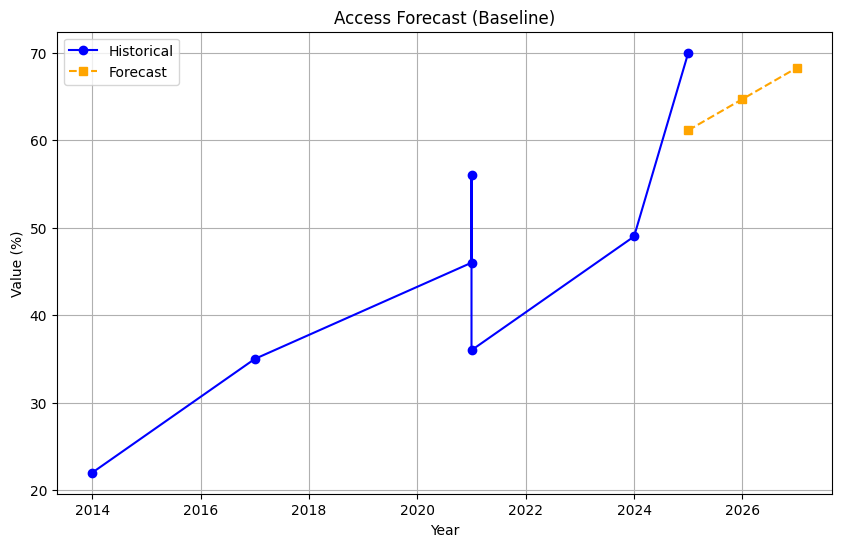

In [8]:
import matplotlib.pyplot as plt

def plot_forecast(hist_df, forecast_df, title):
    plt.figure(figsize=(10, 6))
    
    # Use 'value_numeric' for historical data
    plt.plot(hist_df["year"], hist_df["value_numeric"], marker='o', label="Historical", color="blue")
    
    # Use 'forecast_value' (from your trend_forecast output)
    plt.plot(forecast_df["year"], forecast_df["forecast_value"], marker='s', linestyle='--', label="Forecast", color="orange")
    
    plt.title(title)
    plt.xlabel("Year")
    plt.ylabel("Value (%)")
    plt.legend()
    plt.grid(True)
    plt.show()

# Corrected Historical filtering
hist_access = df[df["indicator_code"] == "ACC_OWNERSHIP"].assign(
    year=lambda x: pd.to_datetime(x["observation_date"]).dt.year
)

# Run plot
plot_forecast(hist_access, access_fc, "Access Forecast (Baseline)")

In [9]:
from src.scenarios import apply_event_adjustment

# 8% growth for optimistic, 5% drop for pessimistic
positive_scenario = apply_event_adjustment(usage_fc, 0.08)
negative_scenario = apply_event_adjustment(usage_fc, -0.05)

# Verify results
print(positive_scenario.head())

   year  forecast_value
0  2025     138564000.0
1  2026     223452000.0
2  2027     308340000.0


In [10]:
# Uncertainty Bands

usage_fc["upper"] = usage_fc["forecast_value"] * 1.1
usage_fc["lower"] = usage_fc["forecast_value"] * 0.9

print(usage_fc.head())


   year  forecast_value        upper        lower
0  2025     128300000.0  141130000.0  115470000.0
1  2026     206900000.0  227590000.0  186210000.0
2  2027     285500000.0  314050000.0  256950000.0


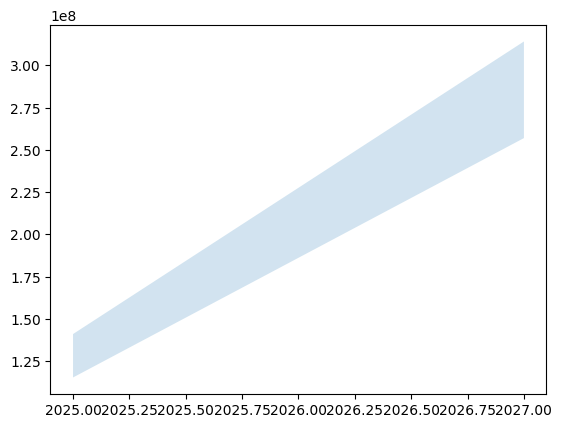

In [11]:
plt.fill_between(
    usage_fc["year"],
    usage_fc["lower"],
    usage_fc["upper"],
    alpha=0.2,
    label="Uncertainty Band"
)


## Methodology

Forecasts are generated using linear trend extrapolation on historical
annual indicators. Event impacts estimated in Task 3 are incorporated
through scenario-based adjustments rather than deterministic shocks.

## Assumptions

- Historical trends remain informative through 2027
- Event impacts persist but weaken over time
- No major unobserved regulatory shocks occur

## Uncertainty

Confidence intervals are heuristic and reflect structural uncertainty
rather than statistical confidence.
